# Open exploration

At policy1 (do nothing except evaculation), run experiments with SOBOL uncertainty sampling (nr scenario = 100).

- At timestep=0, which uncertainty factor(s) has most influence on the outcomes if do nothing? *(feature scoring & sobol)*
- At timestep=0, how is each municipality influenced by the uncertainty factors? *(sobol analysis)*

*Upstream - A1 (Doesburg), A2 (Contenoever), A3 (Zutphen), A4 (Gorssel), A5 (Deventer) - Downstream*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ema_workbench import (MultiprocessingEvaluator,
                           Scenario, Constraint, Policy,
                           ScalarOutcome)
from ema_workbench.em_framework.optimization import EpsilonProgress, HyperVolume
from ema_workbench.em_framework.evaluators import perform_experiments, optimize
from ema_workbench.util import ema_logging, save_results, load_results
from ema_workbench.analysis import (pairs_plotting, prim, 
                                    feature_scoring, parcoords,
                                    dimensional_stacking)

from problem_formulation import get_model_for_problem_formulation
%matplotlib inline
sns.set_style('white')

ema_logging.log_to_stderr(ema_logging.INFO)

C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


<Logger EMA (DEBUG)>

In [2]:
'''
For different list of outcomes:
# 0 = 2-objective PF
# 1 = 3-objective PF
# 2 = 5-objective PF
# 3 = Disaggregate over locations
# 4 = Disaggregate over time
# 5 = Fully disaggregated
'''
dike_model, planning_steps = get_model_for_problem_formulation(5) # assign problem_formulation_id

In [3]:
for lever in dike_model.levers:
    print(repr(lever))

IntegerParameter('0_RfR 0', 0, 1)
IntegerParameter('0_RfR 1', 0, 1)
IntegerParameter('0_RfR 2', 0, 1)
IntegerParameter('1_RfR 0', 0, 1)
IntegerParameter('1_RfR 1', 0, 1)
IntegerParameter('1_RfR 2', 0, 1)
IntegerParameter('2_RfR 0', 0, 1)
IntegerParameter('2_RfR 1', 0, 1)
IntegerParameter('2_RfR 2', 0, 1)
IntegerParameter('3_RfR 0', 0, 1)
IntegerParameter('3_RfR 1', 0, 1)
IntegerParameter('3_RfR 2', 0, 1)
IntegerParameter('4_RfR 0', 0, 1)
IntegerParameter('4_RfR 1', 0, 1)
IntegerParameter('4_RfR 2', 0, 1)
IntegerParameter('EWS_DaysToThreat', 0, 4)
IntegerParameter('A.1_DikeIncrease 0', 0, 10)
IntegerParameter('A.1_DikeIncrease 1', 0, 10)
IntegerParameter('A.1_DikeIncrease 2', 0, 10)
IntegerParameter('A.2_DikeIncrease 0', 0, 10)
IntegerParameter('A.2_DikeIncrease 1', 0, 10)
IntegerParameter('A.2_DikeIncrease 2', 0, 10)
IntegerParameter('A.3_DikeIncrease 0', 0, 10)
IntegerParameter('A.3_DikeIncrease 1', 0, 10)
IntegerParameter('A.3_DikeIncrease 2', 0, 10)
IntegerParameter('A.4_DikeIncreas

In [7]:
# policies allow only evacuation
policyDike = {}
for key in dike_model.levers:
    if 'DikeIncrease' in key.name:  # DikeIncrease
        policyDike.update({key.name: np.arange(0, 11, 1)})
    else:  # RfR and DaysToThreat
        policyDike.update({key.name: np.zeros(11)})
        
policies_to_evaluate = [Policy('policyDike'+str(i), **policy.to_dict()) 
                        for i, policy in pd.DataFrame.from_dict(policyDike).iterrows()]

In [8]:
n_scenarios = 50

In [9]:
%%time
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(scenarios= n_scenarios,
                                            policies = policies_to_evaluate,
                                            uncertainty_sampling='sobol')

save_results(results, './results/sobol_policyDike_50Scenarios_fullyDisaggregated.tar.gz')

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 2000 scenarios * 11 policies * 1 model(s) = 22000 experiments
[MainProcess/INFO] 2200 cases completed
[MainProcess/INFO] 4400 cases completed
[MainProcess/INFO] 6600 cases completed
[MainProcess/INFO] 8800 cases completed
[MainProcess/INFO] 11000 cases completed
[MainProcess/INFO] 13200 cases completed
[MainProcess/INFO] 15400 cases completed
[MainProcess/INFO] 17600 cases completed
[MainProcess/INFO] 19800 cases completed
[MainProcess/INFO] 22000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool
[MainProcess/INFO] results saved successfully to D:\epa1361_open\MBDM-group-11\final assignment\results\sobol_policyDike_50Scenarios_fullyDisaggregated.tar.gz


Wall time: 3h 6min 6s


In [56]:
results = load_results(r'./results/sobol_policyDike_50Scenarios_fullyDisaggregated.tar.gz')

experiments, outcomes = results

[MainProcess/INFO] results loaded succesfully from D:\epa1361_open\MBDM-group-11\final assignment\results\sobol_policyDike_50Scenarios_fullyDisaggregated.tar.gz


In [57]:
# subset only the uncertainties plus DikeIncrease at timestep=0
experiments = experiments.filter(regex=r'(wave shape$|Bmax$|pfail$|Brate$|^discount|(DikeIncrease 0)$)')

experiments.sample(10)

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.5_Brate,A.5_pfail,discount rate 0,discount rate 1,discount rate 2,A.1_DikeIncrease 0,A.2_DikeIncrease 0,A.3_DikeIncrease 0,A.4_DikeIncrease 0,A.5_DikeIncrease 0
18413,107.0,170.93750,1.0,0.208008,149.68750,1.5,0.702148,47.81250,1.5,0.663086,...,1.0,0.901367,2.5,1.5,1.5,9.0,9.0,9.0,9.0,9.0
9496,107.0,290.46875,1.5,0.424316,348.28125,1.0,0.679199,37.96875,1.0,0.858887,...,1.0,0.509277,3.5,2.5,1.5,4.0,4.0,4.0,4.0,4.0
20533,123.0,290.93750,1.0,0.083008,189.68750,1.5,0.077148,247.81250,1.0,0.288086,...,1.0,0.776367,1.5,2.5,2.5,10.0,10.0,10.0,10.0,10.0
9436,103.0,177.96875,1.5,0.138184,251.09375,1.0,0.381348,213.28125,1.5,0.127441,...,1.0,0.884277,1.5,1.5,2.5,4.0,4.0,4.0,4.0,4.0
14608,24.0,210.93750,1.0,0.333008,269.68750,1.0,0.327148,52.81250,1.5,0.538086,...,1.5,0.526367,2.5,1.5,2.5,7.0,7.0,7.0,7.0,7.0
18192,79.0,237.18750,1.5,0.575195,162.81250,1.0,0.032227,162.81250,1.0,0.184570,...,1.0,0.426758,2.5,2.5,1.5,9.0,9.0,9.0,9.0,9.0
9837,124.0,227.96875,1.0,0.669434,181.09375,1.0,0.475098,43.28125,1.0,0.783691,...,1.0,0.415527,2.5,3.5,1.5,4.0,4.0,4.0,4.0,4.0
12227,13.0,77.18750,1.0,0.075195,322.81250,1.5,0.532227,197.81250,1.5,0.684570,...,1.5,0.926758,3.5,3.5,3.5,6.0,6.0,6.0,6.0,6.0
12821,75.0,30.93750,1.0,0.043945,332.81250,1.5,0.125977,112.81250,1.5,0.090820,...,1.5,0.083008,2.5,1.5,1.5,6.0,6.0,6.0,6.0,6.0
10421,83.0,170.93750,1.0,0.106445,232.81250,1.0,0.063477,332.81250,1.5,0.778320,...,1.0,0.895508,2.5,3.5,1.5,5.0,5.0,5.0,5.0,5.0


In [58]:
# subset only the outcomes at timestep=0
outcomes = pd.DataFrame.from_dict(outcomes).filter(regex=r'0$')

outcomes.sample(10)

,A.1_Expected Annual Damage 0,A.1_Dike Investment Costs 0,A.1_Expected Number of Deaths 0,A.2_Expected Annual Damage 0,A.2_Dike Investment Costs 0,A.2_Expected Number of Deaths 0,A.3_Expected Annual Damage 0,A.3_Dike Investment Costs 0,A.3_Expected Number of Deaths 0,A.4_Expected Annual Damage 0,A.4_Dike Investment Costs 0,A.4_Expected Number of Deaths 0,A.5_Expected Annual Damage 0,A.5_Dike Investment Costs 0,A.5_Expected Number of Deaths 0,RfR Total Costs 0,Expected Evacuation Costs 0
15775,0.000000e+00,68139002,0.000000,0.000000e+00,73315450,0.000000,0.000000e+00,34221561,0.000000,0.000000e+00,14261651,0.000000,0.000000e+00,44193513,0.000000,0.0,0.0
11243,0.000000e+00,53972506,0.000000,0.000000e+00,59410102,0.000000,0.000000e+00,28798397,0.000000,2.787081e+06,11068771,0.001882,0.000000e+00,36676675,0.000000,0.0,0.0
4344,0.000000e+00,37255203,0.000000,0.000000e+00,42818415,0.000000,1.011543e+07,22167818,0.013877,0.000000e+00,7332080,0.000000,8.372643e+07,27578229,0.056917,0.0,0.0
3668,0.000000e+00,32694901,0.000000,4.708026e+06,38245121,0.005555,0.000000e+00,20299287,0.000000,1.658579e+07,6320800,0.009512,0.000000e+00,25037214,0.000000,0.0,0.0
8717,0.000000e+00,47847947,0.000000,9.904983e+05,53358573,0.001194,0.000000e+00,26403379,0.000000,0.000000e+00,9695195,0.000000,1.147492e+07,33377116,0.012973,0.0,0.0
17707,0.000000e+00,76299088,0.000000,0.000000e+00,81277411,0.000000,0.000000e+00,37285037,0.000000,0.000000e+00,16108916,0.000000,0.000000e+00,48463701,0.000000,0.0,0.0
18222,0.000000e+00,85264360,0.000000,0.000000e+00,89992006,0.000000,0.000000e+00,40609051,0.000000,0.000000e+00,18144080,0.000000,0.000000e+00,53114002,0.000000,0.0,0.0
2758,8.112197e+08,32694901,0.646317,2.541439e+08,38245121,0.249278,0.000000e+00,20299287,0.000000,0.000000e+00,6320800,0.000000,0.000000e+00,25037214,0.000000,0.0,0.0
12072,0.000000e+00,60717312,0.000000,0.000000e+00,66045103,0.000000,0.000000e+00,31398797,0.000000,0.000000e+00,12586457,0.000000,0.000000e+00,40273672,0.000000,0.0,0.0
15233,0.000000e+00,68139002,0.000000,9.884919e+05,73315450,0.001189,0.000000e+00,34221561,0.000000,0.000000e+00,14261651,0.000000,0.000000e+00,44193513,0.000000,0.0,0.0


## Feature scoring

- At timestep=0, which uncertainty factor(s) has most influence on the outcomes if do nothing?

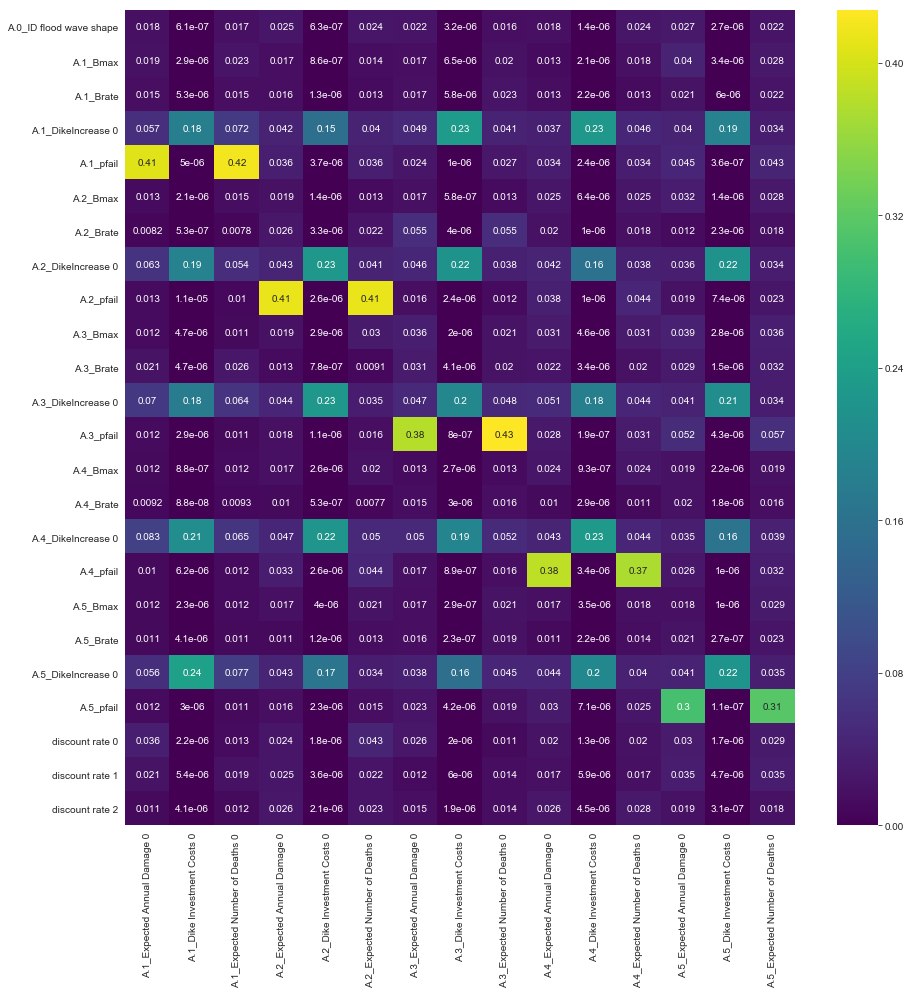

In [26]:
# plot feature scoring at timestep=0
x = experiments
y = outcomes.drop(columns=['RfR Total Costs 0', 'Expected Evacuation Costs 0']) # filter relevant outcomes

fs = feature_scoring.get_feature_scores_all(x, y)
fig, ax = plt.subplots(figsize = (15,15))
sns.heatmap(fs, cmap='viridis', annot=True)

## Sobol

- At timestep=0, which uncertainty factor(s) has most influence on the outcomes if do nothing?
- At timestep=0, how is each municipality influenced by the uncertainty factors? 

In [27]:
from SALib.analyze import sobol
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

problem = get_SALib_problem(dike_model.uncertainties)

In [77]:
def plot_per_municipality_timestep0(KPI):
    # plot assigned outcome KPI for all five municipalities
    fig, axes = plt.subplots(nrows=5, ncols=1, sharex=True, sharey=True)
    fig.suptitle('Sobol score: Uncertainties on {} at timestep=0 per municipality\nAllow only dike heightening'.format(KPI),
                 fontsize = 'x-large', y=0.95)

    for i in range(0, 5): # per municipality
        KPI_i = 'A.{}_{} 0'.format(i+1, KPI) # assign the outcome kpi in interest
            
        Si = sobol.analyze(problem, outcomes[[KPI_i]].values.reshape(-1), 
                           calc_second_order=True, print_to_console=False)

        Si_filter = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
        Si_df = pd.DataFrame(Si_filter, index=problem['names'])

        indices = Si_df[['S1','ST']]
        err = Si_df[['S1_conf','ST_conf']]

        indices.plot.bar(yerr=err.values.T, ax=axes[i], figsize=(12, 8), grid=True)
        axes[i].set_ylabel('A.{}'.format(i+1),
                           fontsize = 'large')
    fig.align_ylabels()

In [78]:
def plot_pfail_per_municipality_timestep0(KPI):
    # plot assigned outcome KPI for all five municipalities, looking only at pfail
    fig, axes = plt.subplots(nrows=5, ncols=1, sharex=True, sharey=True)
    fig.suptitle('Sobol score: pfail on {} at timestep=0 per municipality\nAllow only dike heightening'.format(KPI),
                 fontsize = 'x-large', y=0.95)

    for i in range(0, 5):
        KPI_i = 'A.{}_{} 0'.format(i+1, KPI) # assign the outcome kpi in interest

        Si = sobol.analyze(problem, outcomes[[KPI_i]].values.reshape(-1), 
                           calc_second_order=True, print_to_console=False)

        Si_filter = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
        Si_df = pd.DataFrame(Si_filter, index=problem['names']).filter(regex='pfail$', axis=0)

        indices = Si_df[['S1','ST']]
        err = Si_df[['S1_conf','ST_conf']]

        indices.plot.bar(yerr=err.values.T, ax=axes[i], figsize=(8, 8), grid=True)
        axes[i].set_ylabel('A.{}'.format(i+1),
                           fontsize = 'large')
    fig.align_ylabels()

### Expected Annual Damage

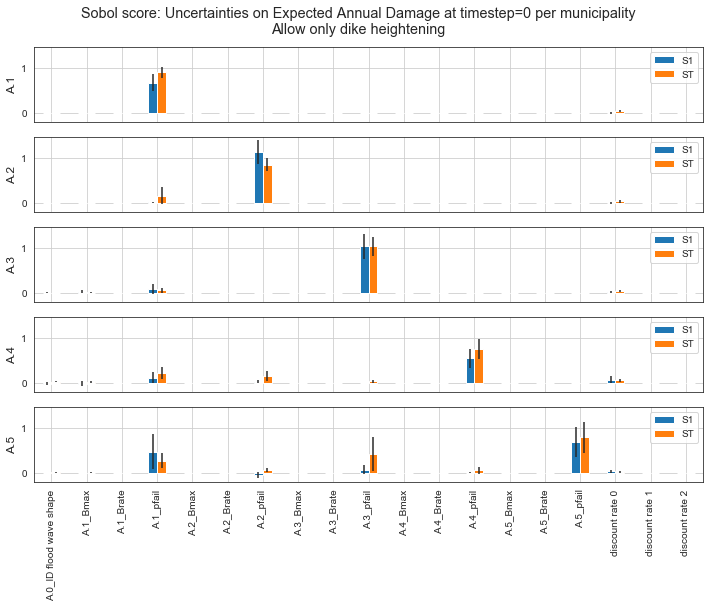

In [79]:
# plot `Expected Annual Damage` at timestep=0 for all five municipalities
plot_per_municipality_timestep0('Expected Annual Damage')

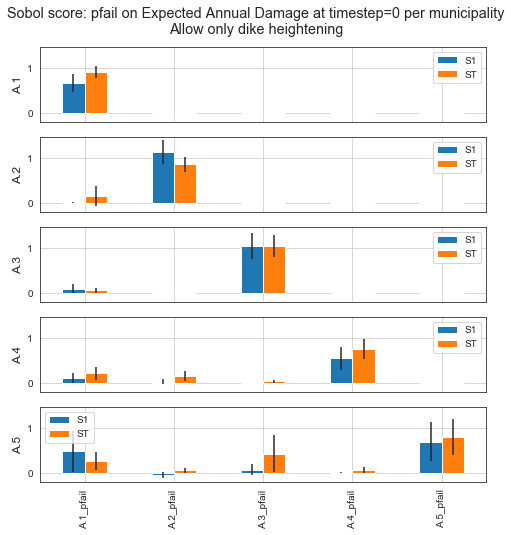

In [80]:
# subset only pfail
plot_pfail_per_municipality_timestep0('Expected Annual Damage')

### Expected Number of Death

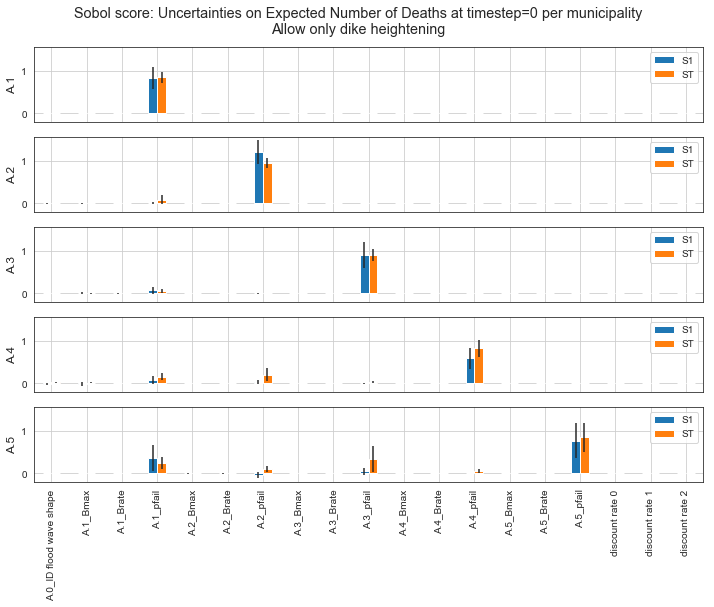

In [81]:
# plot `Expected Number of Deaths` at timestep=0 for all five municipalities
plot_per_municipality_timestep0('Expected Number of Deaths')

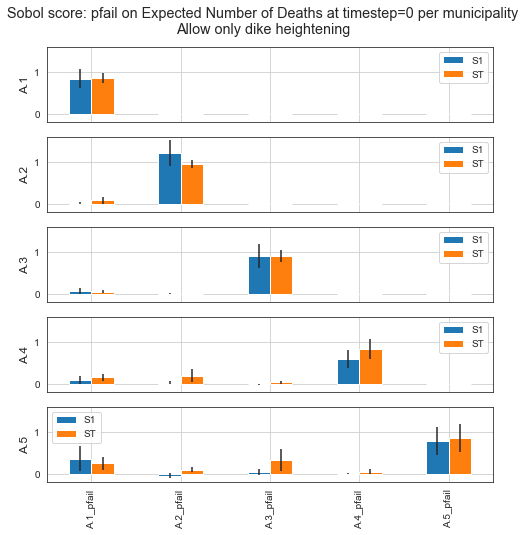

In [82]:
# subset only pfail
plot_pfail_per_municipality_timestep0('Expected Number of Deaths')